## ResNeXt

In [3]:
import tensorflow as tf

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    tf.config.experimental.set_memory_growth(gpus[0], True)
  except RuntimeError as e:
    print(e)
    
from IPython.display import Image

In [4]:
from tensorflow.keras import Model, Input
from tensorflow.keras.layers import Activation, Conv2D, Flatten, Dense, \
                                MaxPooling2D, AveragePooling2D, BatchNormalization, add

### ResNet VS ResNeXt block

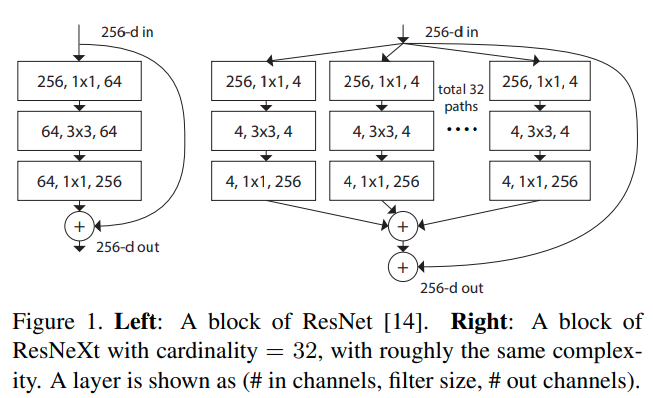

In [5]:
Image('image/resnext_fig1.png')

### ResNet block

In [6]:
def res_conv(filters, kernel_size=3, padding='same', 
             strides=1, activation=True):
    def layer_fn(x):
        x = Conv2D(filters=filters, kernel_size=kernel_size,
                     padding=padding, strides=strides)(x)
        x = BatchNormalization(axis=-1)(x)
        if activation:
            x = Activation('relu')(x)
        return x
    return layer_fn

In [7]:
def merge_with_shortcut():
    def layer_fn(x, x_residual):
        x_shape = tf.keras.backend.int_shape(x)
        x_residual_shape = tf.keras.backend.int_shape(x_residual)
        
        if x_shape == x_residual_shape:
            shortcut = x
        else:
            strides = (
                int(round(x_shape[1] / x_residual_shape[1])), # vertical stride
                int(round(x_shape[2] / x_residual_shape[2])) # horizontal stride    
            )
            x_residual_channels = x_residual_shape[3]
            
            shortcut = Conv2D(
                filters=x_residual_channels, kernel_size=1, 
                padding='valid', strides=strides)(x)
        
        return add([shortcut, x_residual])
    return layer_fn

In [8]:
def resnet_block(filters, kernel_size=3, strides=1,
                name='resnet_block'):
    def layer_fn(x):
        x_residual = res_conv(filters=filters/4, kernel_size=1,
                    padding='valid', strides=strides)(x)
        x_residual = res_conv(filters=filters/4, kernel_size=kernel_size,
                    padding='same', strides=1)(x_residual)
        x_residual = res_conv(filters=filters, kernel_size=1,
                    padding='valid', strides=1, activation=False)(x_residual)
        x = merge_with_shortcut()(x, x_residual)
        x = Activation('relu')(x)
        return x
    return layer_fn

In [9]:
def resnet_block_example(input_shape, num_classes):
    input = Input(shape=input_shape)
    x = resnet_block(256)(input)
    x = Flatten()(x)
    output = Dense(num_classes, activation='softmax', name='output')(x)
    model = Model(inputs=input, outputs=output)
    
    return model

In [10]:
num_classes = 10
input_shape = [32, 32, 256]
batch_input_shape = tf.TensorShape((None, *input_shape))

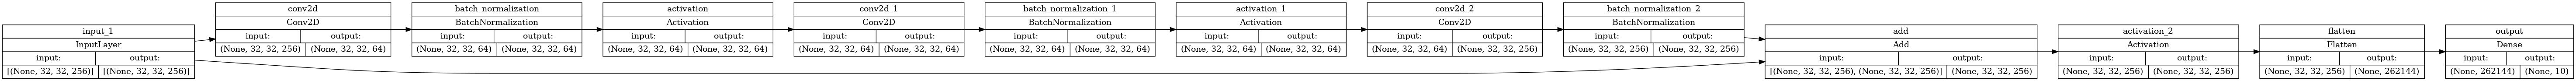

In [11]:
model = resnet_block_example(input_shape, num_classes)
model.build(input_shape=batch_input_shape)

dot_img_file = 'ResNet_block_example.png'
tf.keras.utils.plot_model(model, to_file=dot_img_file, show_shapes=True, rankdir='LR')

### ResNeXt block

In [12]:
def resnext_block(filters, kernel_size=3, strides=1,
                 name='resnext_block'):
    def layer_fn(x):
        residual_groups = []
        for _ in range(32):
            x_residual = res_conv(filters=4, kernel_size=1,
                        padding='valid', strides=strides)(x)
            x_residual = res_conv(filters=4, kernel_size=kernel_size,
                        padding='same', strides=1)(x_residual)
            x_residual = res_conv(filters=filters, kernel_size=1,
                        padding='valid', strides=1, activation=False)(x_residual)
            residual_groups.append(x_residual)
        
        x_residual = add(residual_groups)
        x = merge_with_shortcut()(x, x_residual)
        x = Activation('relu')(x)
        return x
    return layer_fn

In [13]:
def resnext_block_example(input_shape, num_classes):
    input = Input(shape=input_shape)
    x = resnext_block(256)(input)
    x = Flatten()(x)
    output = Dense(num_classes, activation='softmax', name='output')(x)
    model = Model(inputs=input, outputs=output)
    
    return model

In [14]:
num_classes = 10
input_shape = [32, 32, 256]
batch_input_shape = tf.TensorShape((None, *input_shape))

In [15]:
model = resnext_block_example(input_shape, num_classes)
model.build(input_shape=batch_input_shape)

dot_img_file = 'ResNext_block_example.png'
tf.keras.utils.plot_model(model, to_file=dot_img_file, show_shapes=True, rankdir='LR')

## Base Idea

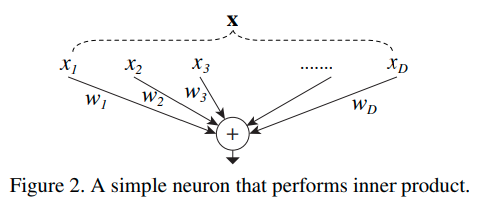

In [16]:
Image('image/resnext_fig2.png')

* inner product 를 수행하는 NN 의 가장 간단한 연산을 splitting, transforming, aggregating 의 조합으로 생각해볼 수 있습니다.
    - Splitting : 벡터 $x$ 가 저차원 임베딩으로 쪼개집니다. (1차원 subspace $x_i$)
    - Transforming : 저차원 표현이 변환됩니다. (단순히 스케일된 $w_i x_i$)
    - Aggregating : 모든 임베딩의 변환이 집계됩니다. ($\sum_{i=1}^D w_i x_i)$
* 위와 같이 간단한 neuron 에서의 분석을 기반하여 $w_i x_i$ 를 보다 일반적인 함수로 대체하는 걸 고려해볼 수 있습니다.

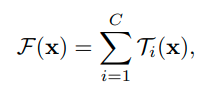

In [17]:
Image('image/resnext_eq2.png')

* 임의의 함수 $\mathcal{T}_i(x)$ 는 x 를 임베딩에 투영한 다음 x 변환해야합니다.
* C(cardinality)는 집계할 변환 집합의 크기입니다. (실험적으로 cardinality 가 매우 중요한 차원이며, width 와 depth 차원보다 더 효율적일 수 있다는 것을 확인했습니다.)